In [1]:
import numpy as np
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import math

In [107]:
plt.rcParams.update({'font.size': 22})

In [158]:
class bls_call(object):
    def __init__(self, series_id, start_year, end_year):
        '''
        See here for https://www.bls.gov/help/hlpforma.htm BLS series id formats.
        '''
        self.series_id = series_id
        self.start_year = start_year
        self.end_year = end_year
        self.df = pd.DataFrame()
        

    def bls_data(self): #series_id, start_year, end_year):
        '''
        Inputs:
        - series_id: SINGLE series_id
        - start_date:  4 digit (eg 2000)
        - end_date: 4 digit (eg 2010)
        '''
        try:
            key = "4a0987d92b974131813039c3ca751276"
            headers = {'Content-type': 'application/json'}

            # function to get a df given an id and date range

            def get_df(series_id, start_year, end_year):
                data = json.dumps({"seriesid": series_id,
                                   "startyear": str(start_year),
                                   "endyear": str(end_year),
                                   'registrationkey': key})
#                 print(data)
                p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
                json_data = json.loads(p.text)
#                 print(json_data)
                df = pd.DataFrame(columns=['year','months','value'])
                for i, series in enumerate(json_data['Results']['series'][0]['data']):
                    df.loc[i] = [series['year'], series['period'], series['value']]
                return df
            
            time_range = self.end_year - self.start_year
            if time_range>10:
                returned_dfs = []
                start_stops = []
                arange = np.arange(self.start_year, self.end_year, 9)
                for i in range(len(arange) - 1):
                    start_stops.append((arange[i], arange[i+1]))
                start_stops.append( (arange[i+1], self.end_year ) )
                for increments in start_stops:
                    returned_dfs.append( get_df(self.series_id, increments[0], increments[1]) )
                final_df =  pd.concat(returned_dfs)
#                 return final_df.sort_values(by = ['year','months'])
                self.df = final_df.sort_values(by = ['year','months'])
#                 return self.df
            else:
#                 return get_df(self.series_id, self.start_year, self.end_year)
#                 print(get_df(self.series_id, self.start_year, self.end_year))
                self.df = get_df(self.series_id, self.start_year, self.end_year)
#                 return self.df
        except TypeError:
            print('''
            Type Error -- this is likely a problem with your API input parameters. Make sure your function\n
                  call is in a list, like so: bls_call([\"LNS14000000\"], 2016,2017)
            '''
                 )
            
    def format_dates(self):
        '''
        take in dataframe from BLS API. return cleaned date col
        '''
        df = self.df
        df['month']= np.where(
                    df['months'] == 'M01', 1,
                        np.where(df['months'] == 'M02', 2,
                        np.where(df['months'] == 'M03', 3, 
                        np.where(df['months'] == 'M04', 4, 
                        np.where(df['months'] == 'M05', 5, 
                        np.where(df['months'] == 'M06', 6, 
                        np.where(df['months'] == 'M07', 7, 
                        np.where(df['months'] == 'M08', 8,
                        np.where(df['months'] == 'M09', 9, 
                        np.where(df['months'] == 'M10', 10, 
                        np.where(df['months'] == 'M11', 11,
                        np.where(df['months'] == 'M12', 12, 'hi'                            
                              ))))))))))))
        df['day'] = 1
        df['date'] = pd.to_datetime(df[['year', 'month','day']])
        df.sort_values(by='date', ascending = True, inplace = True)
        df.set_index('date', inplace = True)
        self.df = df[['value']]
    
    def plot(self, title, save = False, percent_data = True):
        self.fig = plt.figure()
        self.fig.set_size_inches(12, 6, forward = True)
        self.fig.suptitle(title, fontsize=24, fontweight='bold')

        self.ax = self.fig.add_subplot(111)
        self.ax.plot(self.df.value, linewidth=5.0)
        
        # Add labeled most recent point
        self.ax.plot(self.df[self.df.index == self.df.index.max()].index, self.df[self.df.index == self.df.index.max()]['value'], 'bo', markersize=12)
        if percent_data:
            self.ax.text(self.df[self.df.index == self.df.index.max()].index, self.df[self.df.index == self.df.index.max()]['value'], str(self.df[self.df.index == self.df.index.max()]['value'][0])+'%')        
        else:
            self.ax.text(self.df[self.df.index == self.df.index.max()].index, self.df[self.df.index == self.df.index.max()]['value'], str(self.df[self.df.index == self.df.index.max()]['value'][0]))
        
        if save == True:
            self.fig.savefig('{}.png'.format(title), dpi=1000)
    

# UNEMPLOYMENT RATE

In [159]:
un = bls_call(["LNS14000000"], 2000, 2017) # create object for this series id
un.bls_data() # get data
un.format_dates() # clean up df
un_df = un.df # call it is own name
un.plot('Unemployment rate', save = True, percent_data = True)

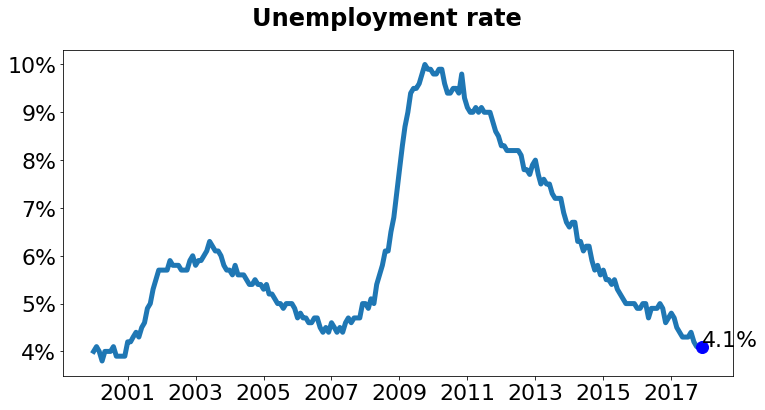

In [160]:
plt.yticks( [4,5,6,7,8,9,10], ('4%', '5%', '6%', '7%', '8%','9%','10%' )) # Custom args
plt.show() # Plot it!

# WITH PLOTLY

In [167]:
import plotly.plotly as py
import plotly.graph_objs as go 

from datetime import datetime
import pandas_datareader.data as web


trace = go.Scatter(x=un_df.index,
                   y=un_df.value,
                   line = dict(
        color = ('rgb(22, 96, 167)'),
        width = 3,))

trace2 = go.Scatter(
    x=['2010-01-01'],
    y=[9],
    mode='markers+text',
    name='Markers and Text',
    text=['Text F'],
    textposition='bottom'
)

data = [trace]
layout = dict(
    title='Unemployment over time',
    font=dict(size=18, color='black'), #family='Courier New, monospace',
    yaxis = dict(
    tickmode = 'array',
    tickvals = [4,5,6,7,8,9,10],
    ticktext = ['4%', '5%', '6%', '7%', '8%','9%','10%']
    ),
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                    label='YTD',
                    step='year',
                    stepmode='todate'),
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig)

# LABOR FORCE PARTICIPATION

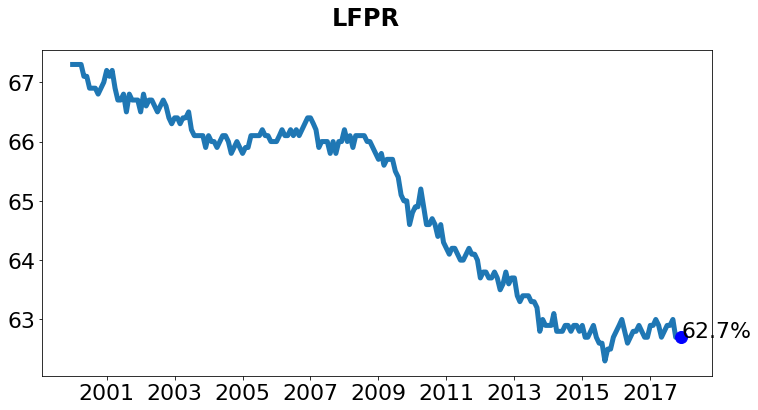

In [161]:
lfpr = bls_call(["LNS11300000"], 2000, 2017) # create object for this series id
lfpr.bls_data() # get data
lfpr.format_dates() # clean up df
lfpr_df = un.df # call it is own name
lfpr.plot('LFPR', save = False)
plt.show()

# EMPLOYMENT TO POPULATION

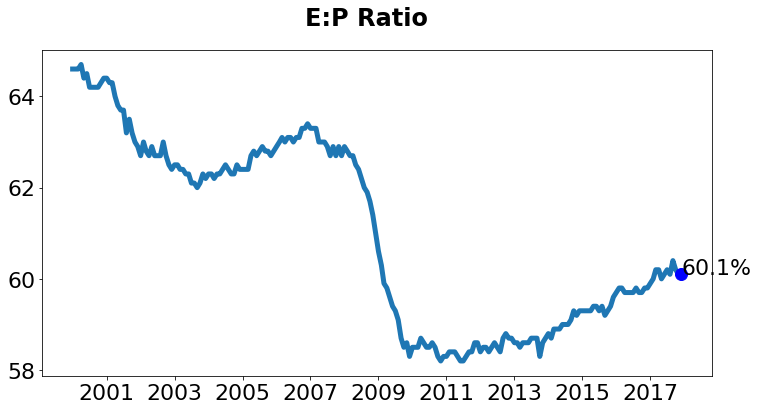

In [162]:
lfpr = bls_call(["LNS12300000"], 2000, 2017) # create object for this series id
lfpr.bls_data() # get data
lfpr.format_dates() # clean up df
lfpr_df = un.df # call it is own name
lfpr.plot('E:P Ratio', save = False)
plt.show()

# LENGTH OF UNEMPLOYMENT

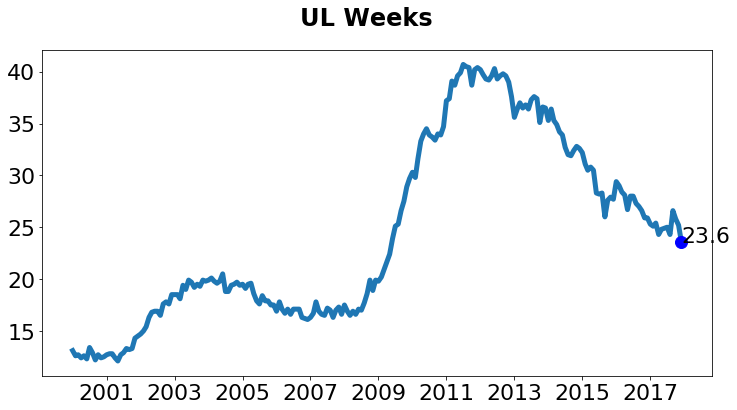

In [166]:
UL = bls_call(["LNS13008275"], 2000, 2017) # create object for this series id
UL.bls_data() # get data
UL.format_dates() # clean up df
UL_df = UL.df # call it is own name
UL.plot('UL Weeks', save = False, percent_data=False)
plt.show()

# LNS12300000

In [99]:
lf = bls_data(["LNS15000000"], 2007, 2017)
# https://data.bls.gov/timeseries/LNS15000000
# 16 years and over
df_lf = format_dates(lf)

pop = bls_data(["LNS10000000"], 2007, 2017)
# :  Civilian noninstitutional population
pop_df = format_dates(pop)

merged_df = pop_df.join(df_lf, lsuffix = 'l')
merged_df[['value','valuel']] = merged_df[['value','valuel']].apply(pd.to_numeric)

In [100]:
merged_df.head()

,yearl,monthsl,valuel,monthl,dayl,year,months,value,month,day
date,,,,,,,,,,
2007-01-01,2007,M01,230650,1,1,2007,M01,77506,1,1
2007-02-01,2007,M02,230834,2,1,2007,M02,77851,2,1
2007-03-01,2007,M03,231034,3,1,2007,M03,77982,3,1
2007-04-01,2007,M04,231253,4,1,2007,M04,78818,4,1
2007-05-01,2007,M05,231480,5,1,2007,M05,78810,5,1


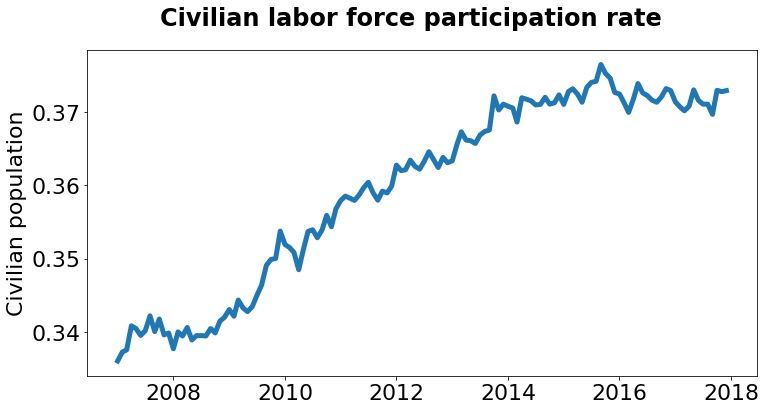

In [102]:

# fig = plt.figure()
# fig.set_size_inches(12, 6, forward = True)

# fig.suptitle('Not in labor force', fontsize=14, fontweight='bold')

# ax = fig.add_subplot(111)
# ax.plot(merged_df.value / merged_df.valuel)

# ax.set_xlabel('Year')
# ax.set_ylabel('Civilian population')
# plt.show()

# fig.savefig('test2png.png', dpi=100)




plt.rcParams.update({'font.size': 22})

fig = plt.figure()
fig.set_size_inches(12, 6, forward = True)
# plt.figure(figsize=(50,50))

fig.suptitle('Civilian labor force participation rate', fontsize=24, fontweight='bold')

ax = fig.add_subplot(111)
ax.plot(merged_df.value / merged_df.valuel, linewidth=5.0)

# ax.plot(lfpr_df.value, linewidth=5.0)

# plt.axvline('2008-9-15', linewidth=3.0, color = 'black')
# plt.text('2009-1-1',4.5,'< Lehman collapse') #,rotation=90)
ax.set_ylabel('Civilian population')

# ax.set_xlabel('Year')
# ax.set_ylabel('LFPR')
# plt.yticks( [63,64,65,66], ('4%', '64%', '65%', '66%', ))
# ax.plot(lfpr[lfpr.index == lfpr.index.max()].index, lfpr[lfpr.index == lfpr.index.max()]['value'], 'bo', markersize=12)
# ax.text(lfpr[lfpr.index == lfpr.index.max()].index, (most_recent+.35)[0], str(most_recent[0])+'%')

plt.show()

fig.savefig('lfpr.png', dpi=1000)

# MEDIAN EARNINGS WEEKLY

In [132]:
med_earn = pd.read_csv('../Desktop/LES1252881600Q.csv', sep = ',')
# https://fred.stlouisfed.org/series/LES1252881600Q
med_earn['DATE'] = pd.to_datetime(med_earn['DATE']) 
med_earn.set_index(med_earn['DATE'], inplace = True)

In [133]:
med_earn.head()

,DATE,LES1252881600Q
DATE,,
1979-01-01,1979-01-01,335
1979-04-01,1979-04-01,335
1979-07-01,1979-07-01,330
1979-10-01,1979-10-01,326
1980-01-01,1980-01-01,321


In [143]:
med_earn[med_earn.index == med_earn.index.max()]['LES1252881600Q']

DATE
2017-10-01    345
Name: LES1252881600Q, dtype: int64

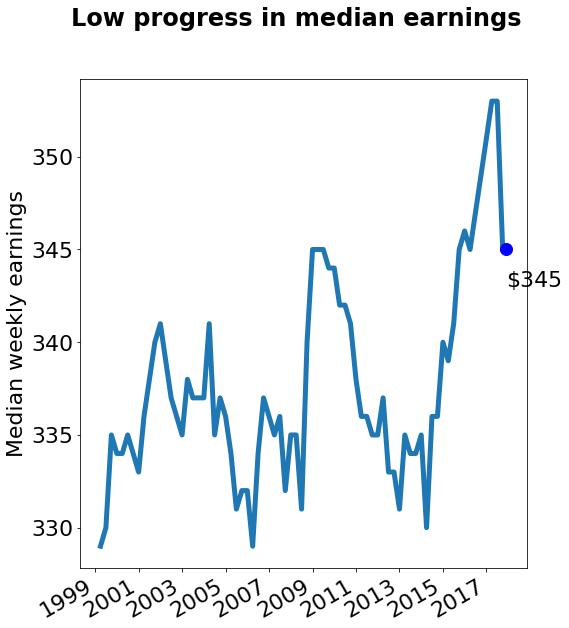

In [154]:

plt.rcParams.update({'font.size': 22})
fig = plt.figure()
fig.set_size_inches(8, 10, forward = True)

fig.suptitle('Low progress in median earnings', fontsize=24, fontweight='bold')

ax = fig.add_subplot(111)
ax.plot(med_earn[med_earn['DATE'] > '1999-01-01'].LES1252881600Q, linewidth=5.0)

ax.set_ylabel('Median weekly earnings')

# ax.set_xlabel('Year')
# ax.set_ylabel('LFPR')
# plt.yticks( [63,64,65,66], ('4%', '64%', '65%', '66%', ))
ax.plot(lfpr[med_earn.index == med_earn.index.max()].index, med_earn[med_earn.index == med_earn.index.max()]['LES1252881600Q'], 'bo', markersize=12)
ax.text(lfpr[med_earn.index == med_earn.index.max()].index, med_earn[med_earn.index == med_earn.index.max()]['LES1252881600Q']-2, '$'+str(med_earn[med_earn.index == med_earn.index.max()]['LES1252881600Q'][0]))
ax.xaxis_date()
fig.autofmt_xdate()


plt.show()
fig.savefig('med_earn.png', dpi=1000)

# REAL MEDIAN INCOME

In [78]:
ls

bls graphing.ipynb   interaction.ipynb    unemp1.png
educpng.png          lfpr.png             wage_prod.png
epr.png              med_earn.png         wage_prod_gap.ipynb
fred_api.ipynb       test3png.png
income_share.ipynb   ue_spell.png


In [85]:
rmi = pd.read_csv('../Desktop/MEHOINUSA672N.csv')
                 
rmi['DATE'] = pd.to_datetime(rmi['DATE'])
# ed.sort_values(by = 'DATE', ascending = True, inplace = True)
rmi.set_index('DATE', inplace = True, drop = False)

In [87]:
rmi.head()

,DATE,MEHOINUSA672N
DATE,,
1984-01-01,1984-01-01,49335
1985-01-01,1985-01-01,50258
1986-01-01,1986-01-01,52068
1987-01-01,1987-01-01,52690
1988-01-01,1988-01-01,53124


In [98]:
np.arange(1984,2017,1)

array([1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

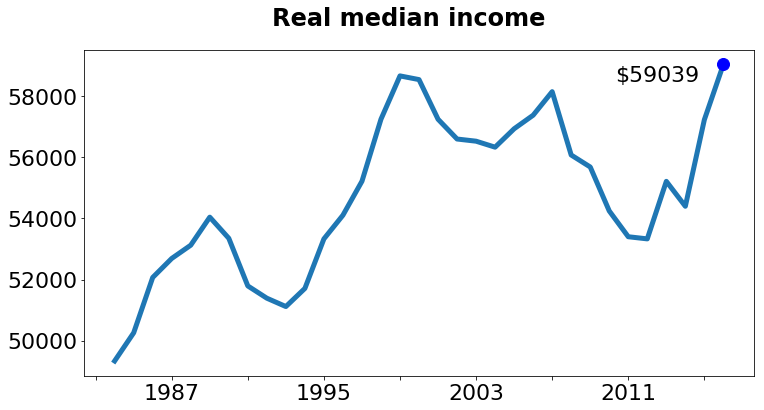

In [110]:

plt.rcParams.update({'font.size': 22})
fig = plt.figure()
fig.set_size_inches(12, 6, forward = True)

fig.suptitle('Real median income', fontsize=24, fontweight='bold')

ax = fig.add_subplot(111)
ax.plot(rmi.MEHOINUSA672N, linewidth=5.0)

# ax.set_ylabel('$')

# ax.set_xlabel('Year')
# ax.set_ylabel('LFPR')
# plt.yticks( [63,64,65,66], ('4%', '64%', '65%', '66%', ))
ax.plot(rmi.index.max(), rmi.MEHOINUSA672N.max(), 'bo', markersize=12)
ax.text('2010-05-01', 58500, '$59039')
# ax.xaxis_date()
# fig.autofmt_xdate()
# plt.xticks( np.arange(1984,2017,1), ('4%', '64%', '65%', '66%', ))

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

plt.show()
fig.savefig('rmi.png', dpi=1000)

# LENGTH OF UE

In [44]:
# ue_spell = pd.read_csv('../Desktop/LNS13008275.csv', sep = ',')
ue_spell = bls_data(["LNS13008275"], 2006, 2017)
ue_spell_df = format_dates(ue_spell)
# https://fred.stlouisfed.org/series/LES1252881600Q
# ue_spell['DATE'] = pd.to_datetime(ue_spell['DATE']) 
# ue_spell.set_index(ue_spell['DATE'], inplace = True)

In [45]:
ue_spell_df.head()

,year,months,value,month,day
date,,,,,
2006-01-01,2006,M01,16.9,1,1
2006-02-01,2006,M02,17.8,2,1
2006-03-01,2006,M03,17.1,3,1
2006-04-01,2006,M04,16.7,4,1
2006-05-01,2006,M05,17.1,5,1


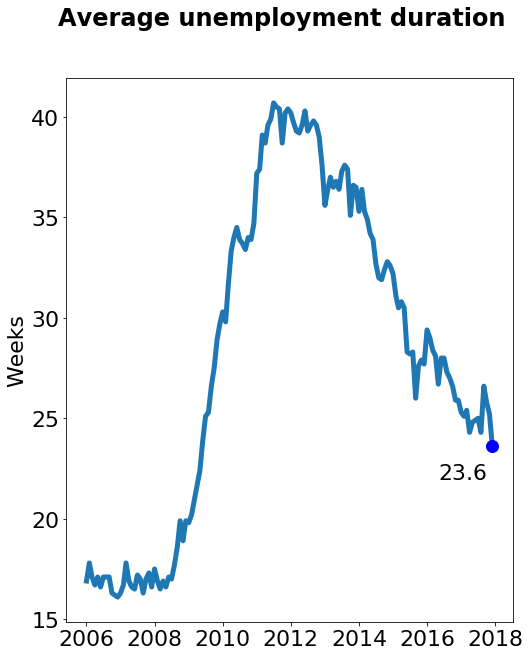

In [55]:

plt.rcParams.update({'font.size': 22})
fig = plt.figure()
fig.set_size_inches(8, 10, forward = True)

fig.suptitle('Average unemployment duration', fontsize=24, fontweight='bold')

ax = fig.add_subplot(111)
ax.plot(ue_spell_df.value, linewidth=5.0)

ax.set_ylabel('Weeks')

# ax.set_xlabel('Year')
# ax.set_ylabel('LFPR')
# plt.yticks( [63,64,65,66], ('4%', '64%', '65%', '66%', ))
ax.plot(ue_spell_df[ue_spell_df.index == ue_spell_df.index.max()].index, ue_spell_df[ue_spell_df.index == ue_spell_df.index.max()]['value'], 'bo', markersize=12)
ax.text('2016-05-01', 22, str(ue_spell_df[ue_spell_df.index == ue_spell_df.index.max()]['value'][0]))
ax.xaxis_date()
# fig.autofmt_xdate()


plt.show()
fig.savefig('ue_spell.png', dpi=1000)

In [34]:
merged_df.dtypes

yearl      object
monthsl    object
valuel     object
monthl     object
dayl        int64
year       object
months     object
value      object
month      object
day         int64
dtype: object

In [25]:
pop = bls_data(["LNS10000000"], 2007, 2017)
pop_df = format_dates(pop)

In [26]:
pop_df.head()

,year,months,value,month,day
date,,,,,
2007-01-01,2007,M01,230650,1,1
2007-02-01,2007,M02,230834,2,1
2007-03-01,2007,M03,231034,3,1
2007-04-01,2007,M04,231253,4,1
2007-05-01,2007,M05,231480,5,1


In [14]:
# education

ed = pd.read_csv('Desktop/ed_perc' ,sep='\t')
ed.sort_values(by = 'year', ascending = True, inplace = True)
ed.set_index('year', inplace = True)


In [15]:
ed.replace(['(NA)'], np.nan, inplace = True)

In [16]:
ed.head(1)

,Total,Aallracesmale,allracesfemale,whitetotal,whitemale,whitefemale,TNHW,TNHWM,TNHWF,black_total,...,Female,Total.2,Male.1,Female.1,Total.3,Male.2,Female.2,Total.4,Male.3,Female.3
year,,,,,,,,,,,,,,,,,,,,,
1940,4.6,5.5,3.8,4.9,5.9,4.0,NaN,NaN,NaN,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


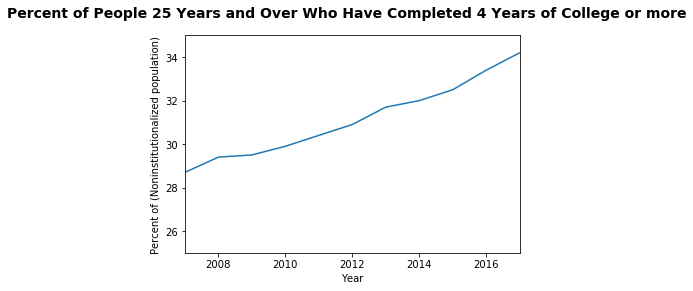

In [17]:
fig1 = plt.figure()
# fig.set_size_inches(12, 6, forward = True)
# plt.figure(figsize=(50,50))

fig1.suptitle('Percent of People 25 Years and Over Who Have Completed 4 Years of College or more', fontsize=14, fontweight='bold')

ax1 = fig1.add_subplot(111)

ax1.plot(ed['Total'])
ax1.set_xlim([2007,2017])
ax1.set_ylim([25,35])

ax1.set_ylabel('Percent of (Noninstitutionalized population)')
ax1.set_xlabel('Year')


# plt.set_xlim(2010, 2017)
plt.show()

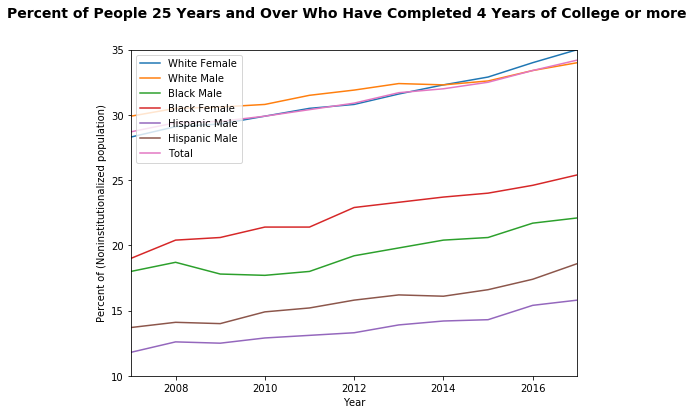

In [20]:
fig2 = plt.figure()
fig2.set_size_inches(8, 6, forward = True)
# plt.figure(figsize=(100,100))

fig2.suptitle('Percent of People 25 Years and Over Who Have Completed 4 Years of College or more', fontsize=14, fontweight='bold')

ax2 = fig2.add_subplot(111)

ax2.plot(ed['whitefemale'])
ax2.plot(ed['whitemale'])

ax2.plot(ed['black_male'])
ax2.plot(ed['black_female'])

ax2.plot(ed['hispanic_male'])
ax2.plot(ed['hispanic_female'])

ax2.plot(ed['Total'])
plt.legend(['White Female', 'White Male', 'Black Male',  'Black Female', 'Hispanic Male' , 'Hispanic Male', 'Total'], loc='upper left')


ax2.set_xlim([2007,2017])
ax2.set_ylim([10,35])

ax2.set_ylabel('Percent of (Noninstitutionalized population)')
ax2.set_xlabel('Year')


# plt.set_xlim(2010, 2017)
plt.show()
fig2.savefig('educpng.png', dpi=300)

In [93]:
ls

Applications/              derby.log
CUUR0000SA0.txt            first-webapp-react/
Desktop/                   galvanize/
Documents/                 helloworld.txt
Downloads/                 job apps/
Library/                   mbox
Movies/                    metastore_db/
Music/                     molly/
Pictures/                  molly.zip
Public/                    nimble/
SUUR0000SA0.txt            nltk_data/
Zotero/                    runa/
all_nimble/                spark-2.2.1-bin-hadoop2.7/
anaconda/                  test/
bls graphing.ipynb         test.py
composetest/               wnowak10.github.io/
data/                      xgboost/
data_science_learning/


In [99]:
stateue = pd.read_csv('Desktop/stateue.tsv',sep='\t')

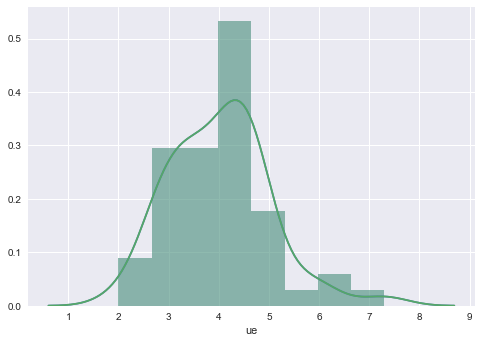

In [102]:
import seaborn as sns
sns.distplot(stateue['ue'])
plt.show()

In [ ]:
fig = plt.figure()
fig.suptitle('Employment over time', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)

ax.plot(lns['value'])
# ax.set_xlabel('Time')
# ax.set_ylabel('Employees in thousands')
plt.show()

In [ ]:
lns

In [ ]:
json_data['Results']['series']

In [ ]:
import requests
import json
# import prettytable
values = []
years = []
months = []
headers = {'Content-type': 'application/json'}
series_id = ['CEU0000000001']
key = "4a0987d92b974131813039c3ca751276"
data = json.dumps({"seriesid": series_id,"startyear":"2008", "endyear":"2017",'registrationkey': key})
print(data)
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)
for series in json_data['Results']['series']:
#     x=prettytable.PrettyTable(["series id","year","period","value","footnotes"])
#     seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        years.append(year)
        period = item['period']
        months.append(period)
        value = item['value']
        values.append(value)
#         footnotes=""
#         for footnote in item['footnotes']:
#             if footnote:
#                 footnotes = footnotes + footnote['text'] + ','
#             if 'M01' <= period <= 'M12':
#                 x.add_row([seriesId,year,period,value,footnotes[0:-1]])
#     output = open(seriesId + '.txt','w')
#     output.write (x.get_string())
#     output.close()


In [ ]:
di = {'year': years, 'months': months, 'values': values}

In [ ]:
df = pd.DataFrame(di)

In [ ]:
df.head()

In [ ]:
ddf['month']= np.where(
                ddf['months'] == 'M01', 1,
                    np.where(ddf['months'] == 'M02', 2,
                    np.where(ddf['months'] == 'M03', 3, 
                    np.where(ddf['months'] == 'M04', 4, 
                    np.where(ddf['months'] == 'M05', 5, 
                    np.where(ddf['months'] == 'M06', 6, 
                    np.where(ddf['months'] == 'M07', 7, 
                    np.where(ddf['months'] == 'M08', 8,
                    np.where(ddf['months'] == 'M09', 9, 
                    np.where(ddf['months'] == 'M10', 10, 
                    np.where(ddf['months'] == 'M11', 11,
                    np.where(ddf['months'] == 'M12', 12, 'hi'                            
                          ))))))))))))
ddf['day'] = 1

In [ ]:
df['date'] = pd.to_datetime(ddf[['year', 'month','day']])

In [ ]:
df.head()

In [ ]:
fig = plt.figure()
fig.suptitle('Employment over time', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)

ax.plot(df['values'])
ax.set_xlabel('Time')
ax.set_ylabel('Employees in thousands')
plt.show()

In [ ]:
# sns.tsplot(df, time = "data", value = "values")

In [ ]:
LNS14000000

In [ ]:
df

In [ ]:
pd.read_txt('CUUR0000SA0.txt')

In [ ]:
values = []
years = []
months = []
headers = {'Content-type': 'application/json'}
series_id = ['LNS14000000']
key = "4a0987d92b974131813039c3ca751276"
data = json.dumps({"seriesid": series_id,"startyear":"2007", "endyear":"2017",'registrationkey': key})

p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)
for series in json_data['Results']['series']:
#     x=prettytable.PrettyTable(["series id","year","period","value","footnotes"])
#     seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        years.append(year)
        period = item['period']
        months.append(period)
        value = item['value']
        values.append(value)
di = {'year': years, 'months': months, 'values': values}
df = pd.DataFrame(di)
ddf['month']= np.where(
                ddf['months'] == 'M01', 1,
                    np.where(ddf['months'] == 'M02', 2,
                    np.where(ddf['months'] == 'M03', 3, 
                    np.where(ddf['months'] == 'M04', 4, 
                    np.where(ddf['months'] == 'M05', 5, 
                    np.where(ddf['months'] == 'M06', 6, 
                    np.where(ddf['months'] == 'M07', 7, 
                    np.where(ddf['months'] == 'M08', 8,
                    np.where(ddf['months'] == 'M09', 9, 
                    np.where(ddf['months'] == 'M10', 10, 
                    np.where(ddf['months'] == 'M11', 11,
                    np.where(ddf['months'] == 'M12', 12, 'hi'                            
                          ))))))))))))
ddf['day'] = 1
df['date'] = pd.to_datetime(ddf[['year', 'month','day']])
df.sort_values(by = 'date', inplace = True)

In [ ]:
fig = plt.figure()
fig.suptitle('Employment over time', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)

ax.plot(df['values'])
ax.set_xlabel('Time')
ax.set_ylabel('Employees in thousands')
plt.show()

In [ ]:
df.head(50)

In [ ]:
# import requests
# import json
# import prettytable
# headers = {'Content-type': 'application/json'}
# data = json.dumps({"seriesid": ['CUUR0000SA0','SUUR0000SA0'],"startyear":"2011", "endyear":"2014"})

In [ ]:
# data

In [ ]:
# p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)

In [ ]:
# p.json()

In [ ]:
import requests

In [ ]:
key = "4a0987d92b974131813039c3ca751276"

In [ ]:
BASE_URL = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

In [ ]:
data = {'registrationkey': key, 'seriesid': 'CEU0800000001', 'startyear': 2008, 'endyear':2017}

In [ ]:
d = requests.post(BASE_URL, data=data).json()["Results"]

In [ ]:
d['series'][0]['data']

In [ ]:
x = str(d['series'][0]['data'])

In [ ]:
requests.post(BASE_URL, data=data).json()["Results"]

In [ ]:
data = {'seriesid': 'CEU0800000003', 'startyear': 2000, 'endyear':2015}

In [ ]:
# x = json.loads(str(d))

In [ ]:
x = json.loads(x)


In [ ]:

# f = csv.writer(open("test.csv", "wb+"))

# # Write CSV Header, If you dont need that, remove this line
# f.writerow(["year"]) #, "model", "codename", "name", "content_type"])

# for x in x:
#     f.writerow([x['year']])#,
#                 x["model"],
#                 x["fields"]["codename"],
#                 x["fields"]["name"],
#                 x["fields"]["content_type"]])

In [ ]:
x

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
from bls import get_series

In [ ]:
get_series('CEU0000000001', 2000, 2017)

In [ ]:
df = pd.DataFrame(get_series('CEU0000000001', 2000, 2017))

In [ ]:
get_series('CEU0800000002', 2000, 2017)

In [ ]:
df['CEU0000000002'] = pd.Series(get_series('CEU0000000002', 2000, 2017))

In [ ]:
df.head()

In [ ]:
df = df.reset_index()

In [ ]:
plt.plot(df.CEU0000000001)
plt.plot(df.CEU0000000002)
plt.show()

In [ ]:
df.head()

In [ ]:
df['index']

In [ ]:
import seaborn as sns

In [ ]:
sns.tsplot(time='index', value = 'CEU0000000001', data=df)

In [ ]:
plt.show()

In [ ]:
pd.to_datetime(df.index)

In [ ]:
df.head()

In [ ]:
sns.tsplot(time='index', value = 'CEU0000000001', data=df)
plt.show()